# Data synthesis using generative adversarial networks (GANs)

In this practical session we will build and train generative adversarial networks that are able to generate images.

This is a Google Colab notebook, which is mostly the same as a Jupyter notebook. This means that you can run the code in a cell by selecting the cell and pressing Shift+Enter. We will run everything in the cloud, so you don't need a fancy computer or an expensive GPU for this exercise. We are going to use GPUs that Google Cloud provides for free. To do this, go to Edit --> Notebook settings and select GPU as Hardware accelerator. Then, in the top right of this screen select 'CONNECT' --> 'Connect to hosted runtime'

We are going to import some of the packages that we will need in this exercise (by running the cell below)

The documentation for key packages can be found online: <br>
For numpy: https://docs.scipy.org/doc/numpy-dev/user/quickstart.html <br>
For matplotlib: http://matplotlib.org/api/pyplot_api.html <br>
For Keras: https://keras.io/ <br>
For random: https://docs.python.org/2/library/random.html <br>

In [2]:
import pickle
import gzip
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc
from matplotlib import pylab
from IPython import display

import tensorflow as tf
from tensorflow import keras
keras.backend.set_image_data_format('channels_first')

import time
import random
from google.colab import files
from google.colab import widgets
random.seed(0)

# Check whether we're using a GPU
#device_name = tf.test.gpu_device_name()
#if device_name != '/device:GPU:0':
#  raise SystemError('GPU device not found')
#print('Found GPU at: {}'.format(device_name))

#tf.logging.set_verbosity(tf.logging.ERROR)

## Small steps
Before moving on to generating images, we will start with a simple 1D problem. We will assume that there is a data set of real samples that are drawn from a normal distribution with a particular mean value (the black dotted line below). These samples are in the sample domain *x*.

The generator network does not know anything about the distribution of the real samples in the sample domain *x*, but will try to come up with a transformation that maps random noise from a distribution *z* to samples that seem to come from the real sample distribution (the green line below). This is very similar to what we have looked at in the lecture.

<img src="https://cs.stanford.edu/people/karpathy/gan/gan.png">

For this, we will define two neural networks that play a game:
*   The discriminator will learn to distinguish real and fake samples in *z*
*   The generator will generate fake samples in *z* that the discriminator cannot discriminate

First, we determine the mean value of the normal distribution from which **real** samples will be drawn in the sample domain *x*. In addition, we define the dimensionality of the normal distribution *z* from which noise samples to the generator will be drawn, i.e. the latent space. This will be 1 for now.

In [ ]:
real_mean = 8
latent_dim = 1

Next, we define our discriminator and generator. These are both very simple networks.

**Question** How many layers does each of these networks have?

Each of the networks has 3 layers, two of them are dense layers and one of them is LeakyReLU.

**Question** Can you find out how many trainable parameters the networks have?

The generator network has 97 trainable parameters, whilde the discriminator network has 0 trainable parameters.

**Question** What are the activation functions of both networks? Why are they like this?

ReLU is used as the standard activation function for almost all layers. Only the last dense layer of the discriminator has a sigmoid activation function. In this layer the sigmoid function is used since an output between 0 an 1 is needed to set a treshold the discriminator can use. A ReLu function can give an output any number greater then zero.

In [ ]:
# For easier reading
from keras.layers import Reshape, Dense, Dropout, Flatten
from keras.layers import LeakyReLU

# The discriminator will directly classify the input value
def get_discriminator_1D():
  discriminator = keras.models.Sequential()
  discriminator.add(Dense(32, input_dim=1))
  discriminator.add(LeakyReLU())
  discriminator.add(Dense(1, activation='sigmoid'))
  return discriminator

# The generator will transform a single input value
def get_generator_1D():
  generator = keras.models.Sequential()
  generator.add(Dense(32, input_dim=1))
  generator.add(LeakyReLU())
  generator.add(Dense(1))
  return generator

Now, we will define the training functions for both networks. Consider what is actually happening in a GAN and how the inputs and outputs are connected. There are three variables when training this GAN

*   **z**: the noise that will be input to the generator
*   **G_z**: the output of the generator, i.e. the samples that should approximate the real samples
*   **D_G_z**: the discriminator's decision based on the fake sample

The overall objective function of our system is as follows

$V^{(D)}(D,G)=\underset{x\sim p_{data}}{\mathbb{E}} [\log{D(x)}]+\underset{z\sim p_z}{\mathbb{E}} [\log{(1-D(G(z)))}]$

The generator $G$ is trying to minimize this loss, and the discriminator $D$ tries to maximize this. In other words, the discriminator wants to minimize the binary cross-entropy s.t. it predicts 1 for real samples and 0 for fake samples. At the same time, the generator tries to get the discriminator to predict 1 for fake samples.




In [ ]:
# Get networks
discriminator = get_discriminator_1D()
generator = get_generator_1D()

# Configure both models for training
discriminator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5))
generator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5))

# To configure the full model, we will set the 'trainable' parameter of the discriminator to False, as we don't want to optimize the discriminator when optimizing the generator
discriminator.trainable = False

# The input variable (noise) for the generator
z = keras.layers.Input(shape=(latent_dim,))

# What comes out of the generator
G_z = generator(z)

# What comes out of the discriminator when classifying the 'fake' samples
D_G_z = discriminator(G_z)

# The full GAN model
gan = keras.models.Model(inputs=z, outputs=D_G_z)

# The loss function for the GAN: this gets lower if the fake samples are classified as real
gan.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5))

The code below runs the training loop. This could take a while. The code will periodically show a plot of the current situation.

**Question** Why do we set discriminator.trainable to either True or False?

The problem we want to solve is to train a generator to create a realistic outcome. If we train the discriminator at the same time as the generator the generator won't get proper feedback from discriminator to generate better results and discriminator will misclassify generated data. To resolve this problem the discriminator.trainable is set to false, since this will ensure the discriminator will not train its parameters.

""


3/3 [==============================] - 0s 3ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 4ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 3ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 3ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 3ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 4ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 3ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 4ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 3ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 3ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 3ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 4ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 3ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 3ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 4ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 4ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 4ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 4ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 3ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 4ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 5ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 10ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 4ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 6ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 5ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 5ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 4ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 5ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 4ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 5ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 5ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 5ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 4ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 5ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 4ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 5ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 5ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 6ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 5ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 6ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 3ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 6ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 3ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 6ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 5ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 4ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 5ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 4ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 5ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 3ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 4ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 3ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 6ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 3ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 5ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 2ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 5ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 6ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 6ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 4ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 7ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 3ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 5ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 7ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 3ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 3ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 3ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 3ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 4ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 7ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 7ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 3ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 7ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 6ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 4ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 6ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 7ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 3ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 6ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 3ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 6ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 8ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 4ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 7ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 3ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 4ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 5ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 2ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 3ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 3ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 4ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 3ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 9ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 4ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 7ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 7ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 3ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 6ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 5ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 8ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

4/4 [==============================] - 0s 5ms/step


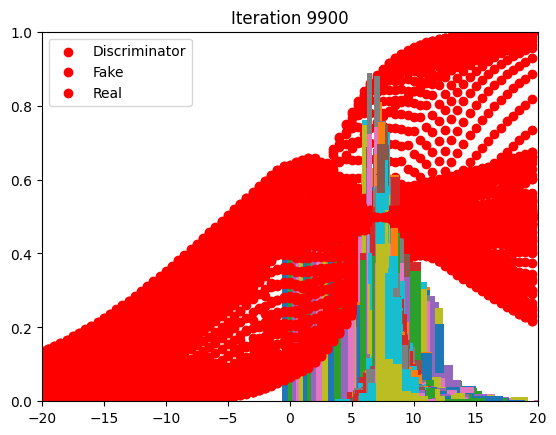

In [ ]:
# We will store the losses here
g_losses = []
d_losses = []

# Training loop
n_samples = 100
epochs = 10000

grid = widgets.Grid(1, 1)

for e in range(epochs):
  # Get a random set of input noise
  noise = np.random.normal(0, 1, size=[n_samples, latent_dim])

  # Also get a sample from the 'real' distribution
  real = np.random.normal(real_mean, 1, size=[n_samples, latent_dim])

  # Generate some fake samples using the generator
  fake = generator.predict(noise)

  # Concatenate the fake and real images
  X = np.concatenate([real, fake])

  # Labels for generated and real data
  Y_dis = np.zeros(2*n_samples)

  # Set labels for real samples to 1
  Y_dis[:n_samples] = 1

  # Train discriminator with this batch of samples
  discriminator.trainable = True
  d_loss = discriminator.train_on_batch(X, Y_dis)
  d_losses.append(d_loss)

  # Train generator with a new batch of generated samples
  # Freeze the discriminator part
  discriminator.trainable = False
  noise = np.random.normal(0, 1, size=[n_samples, latent_dim])
  # From the generator's perspective, the discriminator should predict
  # ones for all samples
  Y_gen = np.ones(n_samples)
  g_loss = gan.train_on_batch(noise, Y_gen)
  g_losses.append(g_loss)

  if e % 100 == 0:
    noise = np.random.normal(0, 1, size=[n_samples, latent_dim])
    fake = generator.predict(noise)
    real = np.random.normal(real_mean, 1, size=[n_samples, latent_dim])
    pred = discriminator.predict(np.arange(-20, 20, 0.5).reshape((80, 1)))
    with grid.output_to(0, 0):
      grid.clear_cell()

      # plt.clf()
      pylab.hist((np.squeeze(fake), np.squeeze(real)), density=True, stacked=True)
      pylab.scatter(np.arange(-20, 20, 0.5), pred, c='r')
      pylab.xlim(-20, 20)
      pylab.ylim(0, 1)
      pylab.title('Iteration {}'.format(e))
      pylab.legend(['Discriminator', 'Fake', 'Real'])
    time.sleep(0.5)

If all is well, the fake and real distributions should nicely overlap after training. The discriminator has essentially pushed the fake samples towards the real distribution and the generator is now able to transform the noise distribution into a distribution of 'real' samples!

**Question** Can you explain what happened to the red line during training? Why does it look like it does after training?

At the beginning the lines form a sigmoid functoin, starting from zero and finishing in one. During training the red line changes, in the end it does not linger finish in one, but now it finishes < 1. This means that the predictor can predict with a lower probability that the generated sample is not real. The predictor is starting to doubt itself, because the generator is learning.

**Question** Try training the GAN with different input noise distributions, e.g. uniform.

After changing the noises form normal to uniform the model was retrained.

**Question** See if you can find a distribution for the real samples for which the generator fails to generate samples.

The numpy.random.pareto() distribution results in a model that where the generator fails to generate samples.

During training, we have stored the loss values for the discriminator and the generator. We can now plot these. Remember that for the digit classification task, we were looking for a set of parameters leading to a low loss function.

**Question** The loss curves that you get look different. Can you explain why they're not nicely dropping to zero? Can you explain the loss in the discriminator based on the objective function of the discriminator?

Since both the discriminator and the generator are trained at the same time it is really hard for both models to obtain a conisstant output. When one model starts working better, the other one is doing a bit worse. Therefore the loss functions will not nicely drop to zero.
The discriminator has a sigmoid function as objective funciton. Whith this objective function the Binary Cross Entropy loss funciton is the most widely used one. The continuous nature of the loss function helps the training process converged well, this can also be seen in the plot where the loss converges for the discriminator, but not for the generator.

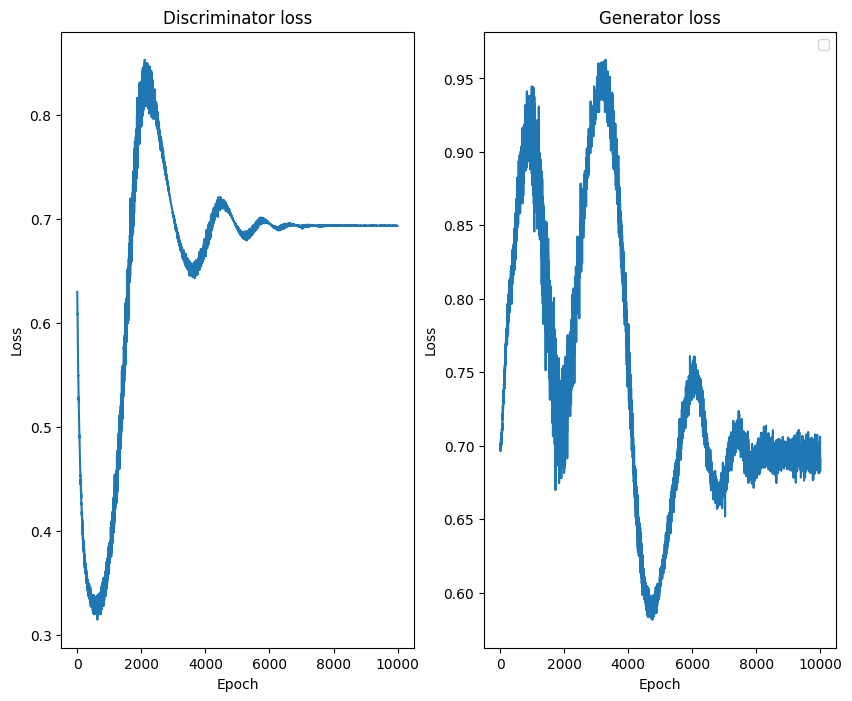

In [ ]:
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(d_losses)
plt.title('Discriminator loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1, 2, 2)
plt.plot(g_losses)
plt.title('Generator loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Although it is definitely nice that we can train two networks together to learn the distribution of a real data distribution, generating samples from a normal distribution is in itself not really interesting. Luckily, we can use the same principles to generate images.

# MNIST synthesis
Like last week, we are again going to use MNIST data. Data preparation is the same as before.

In [ ]:
from keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# load the MNIST the dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# scale the image intensities to the 0-1 range
x_train = (x_train / 255.0).astype(np.float32)
x_test = (x_test / 255.0).astype(np.float32)

# convert the data to channel-last
train_set_images = np.expand_dims(x_train, axis=-1)
test_set_images = np.expand_dims(x_test, axis=-1)

# convert the labels to one-hot encoded
train_set_labels = to_categorical(y_train, num_classes=10)
test_set_labels = to_categorical(y_test, num_classes=10)

11490434/11490434 [==============================] - 0s 0us/step


Plot some images.

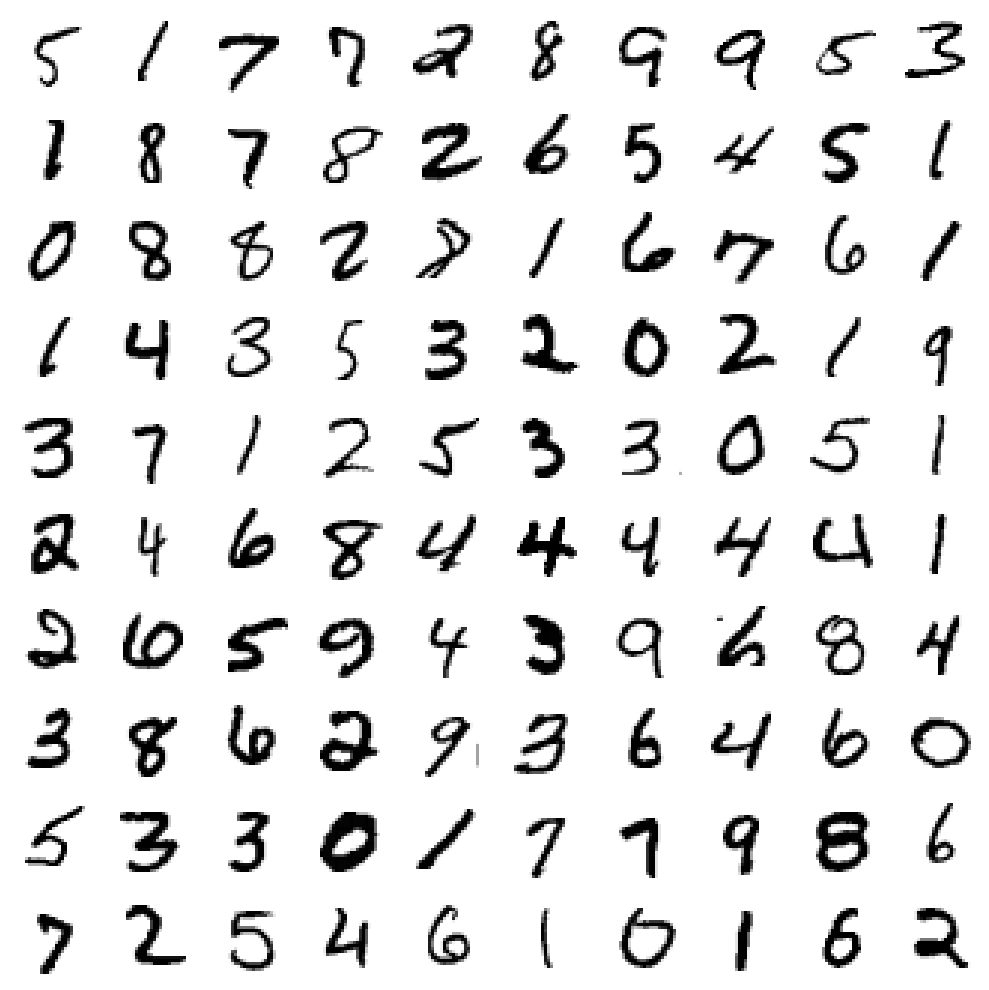

In [ ]:
def plotImages(images, dim=(10, 10), figsize=(10, 10), title=''):
    plt.figure(figsize=figsize)
    for i in range(images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.suptitle(title)
    plt.show()

plotImages(train_set_images[np.random.randint(0, train_set_images.shape[0], size=100)].reshape(100, 28, 28))

In last week's exercise you have built a discriminative model that was able to classify an image into one of ten digit categories. In this exercise, we are going to do the inverse. Given a point in a latent space (which in our case will be a multi-dimensional Gaussian distribution), we are going to train the network to generate a realistic digit image for this point. The MNIST data set will be used as a set of real samples.

<img src="https://skymind.ai/images/wiki/GANs.png">



## The discriminator
As you can see in the image above, we will need a generator and a discriminator network. Let's define these. Consider the network that you used
for digit classification in the previous exercise and see if you can spot some differences between that network and the network below.

**Question** Is this a convolutional neural network? Why (not)?

No, this is not a convolutional neural network, since the discriminator and generator do not contain any convolutional layers in their network.


In [ ]:
def get_discriminator_MLP():
  discriminator = keras.models.Sequential()
  discriminator.add(Dense(1024, input_dim=784, kernel_initializer=keras.initializers.RandomNormal(stddev=0.02)))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(Dropout(0.3))
  discriminator.add(Dense(512))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(Dropout(0.3))
  discriminator.add(Dense(256))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(Dense(1, activation='sigmoid'))
  return discriminator

You could argue that digits are a bit more complex than samples from a Gaussian distribution, so let's set the latent space dimensionality for noise sampling a bit higher than 1.

In [ ]:
latent_dim = 10


## The generator

The generator is different than the discriminator. It should go from a low-dimensional noise vector to an MNIST image.

In [ ]:
from tensorflow.keras.layers import Dense,LeakyReLU, Dropout

def get_generator_MLP():
  generator = keras.models.Sequential()
  generator.add(Dense(256, input_dim=latent_dim, kernel_initializer=keras.initializers.RandomNormal(stddev=0.02)))
  generator.add(LeakyReLU(0.2))
  generator.add(Dense(512))
  generator.add(LeakyReLU(0.2))
  generator.add(Dense(1024))
  generator.add(LeakyReLU(0.2))
  generator.add(Dense(784, activation='tanh'))
  return generator

**Question** Consider the activation functions of the output layers of the generator and discriminator networks. How are they different?

The discriminator uses a sigmoid activation function in the output layer and the generator uses a tanh activation function. The sigmoid activation function outputs a value in the range (0,1). It is nonlinear and when the value is close to 1, the neuron is activated. If it is close to 0 it corresponds to an inactive neuron. The tanh function is a stretched version of the sigmoid function with a range of (-1,1). Both functions have a s-shape, but different gradients. Tanh has a gradient that is 4 times bigger, which results in higher gradients during training and larger updates in the weights of the network.

**Question** Also look at the activation functions of the other layers, can you find out what they do? Look at the Keras documentation.

Leaky ReLu activation functions are also used. This is a variant of the general ReLu function. For a positive x, the leaky ReLu behaves like the ReLu function. However, for negative values of x, it returns a small negative value. This way it solves the problem of dying ReLu in which neurons with a negative bias are never activated.

## The model
Now  let's combine the generator and the discriminator. We train both using a binary crossentropy objective. This is very similar to what we did before.

In [ ]:
discriminator = get_discriminator_MLP()
generator = get_generator_MLP()

discriminator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5))
generator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5))

discriminator.trainable = False
z = keras.layers.Input(shape=(latent_dim,))
G_z = generator(z)
D_G_z = discriminator(G_z)
gan = keras.models.Model(inputs=z, outputs=D_G_z)
gan.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5))

Some helper functions.

In [ ]:
def saveModels(epoch):
    generator.save('gan_generator_epoch_{}.h5'.format(epoch))
    discriminator.save('gan_discriminator_epoch_{}.h5'.format(epoch))

def plotGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, latent_dim])
    generatedImages = generator.predict([noise, l)
    generatedImages = generatedImages.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.suptitle('Epoch {}'.format(epoch))
    plt.show()

Run the code below to train the GAN model. Synthesized images should be shown periodically.

In [ ]:
d_losses = []
g_losses = []

epochs = 70
batch_size = 128

X_train = (train_set_images.reshape(60000, 784).astype(np.float32) - 0.5)/0.5

batch_count = int(X_train.shape[0] / batch_size)
for e in range(epochs):
  for _ in range(batch_count):

    # Get a random set of input noise and images
    noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
    image_batch = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]

    # Generate some fake MNIST images using the generator
    generated_images = generator.predict(noise)

    # Concatenate the fake and real images
    X = np.concatenate([image_batch, generated_images])

    # Labels for generated and real data
    y_dis = np.zeros(2*batch_size)
    # One-sided label smoothing
    y_dis[:batch_size] = 0.9

    # Train discriminator with this batch of samples
    discriminator.trainable = True
    d_loss = discriminator.train_on_batch(X, y_dis)

    # Train generator with a new batch of generated samples
    noise = np.random.normal(0, 1, size=[batch_size, latent_dim])

    # From the generator's perspective, the discriminator should predict
    # ones for all samples
    y_gen = np.ones(batch_size)

    # Freeze the discriminator part
    discriminator.trainable = False

    # Train the GAN to predict ones
    g_loss = gan.train_on_batch(noise, y_gen)

  # Store loss of most recent batch from this epoch
  d_losses.append(d_loss)
  g_losses.append(g_loss)

  if e % 5 == 0:
    noise = np.random.normal(0, 1, size=[100, latent_dim])
    plotGeneratedImages(e)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(0.001)
    saveModels(e)



4/4 [==============================] - 0s 6ms/step


<Figure size 640x480 with 0 Axes>

4/4 [==============================] - 0s 3ms/step


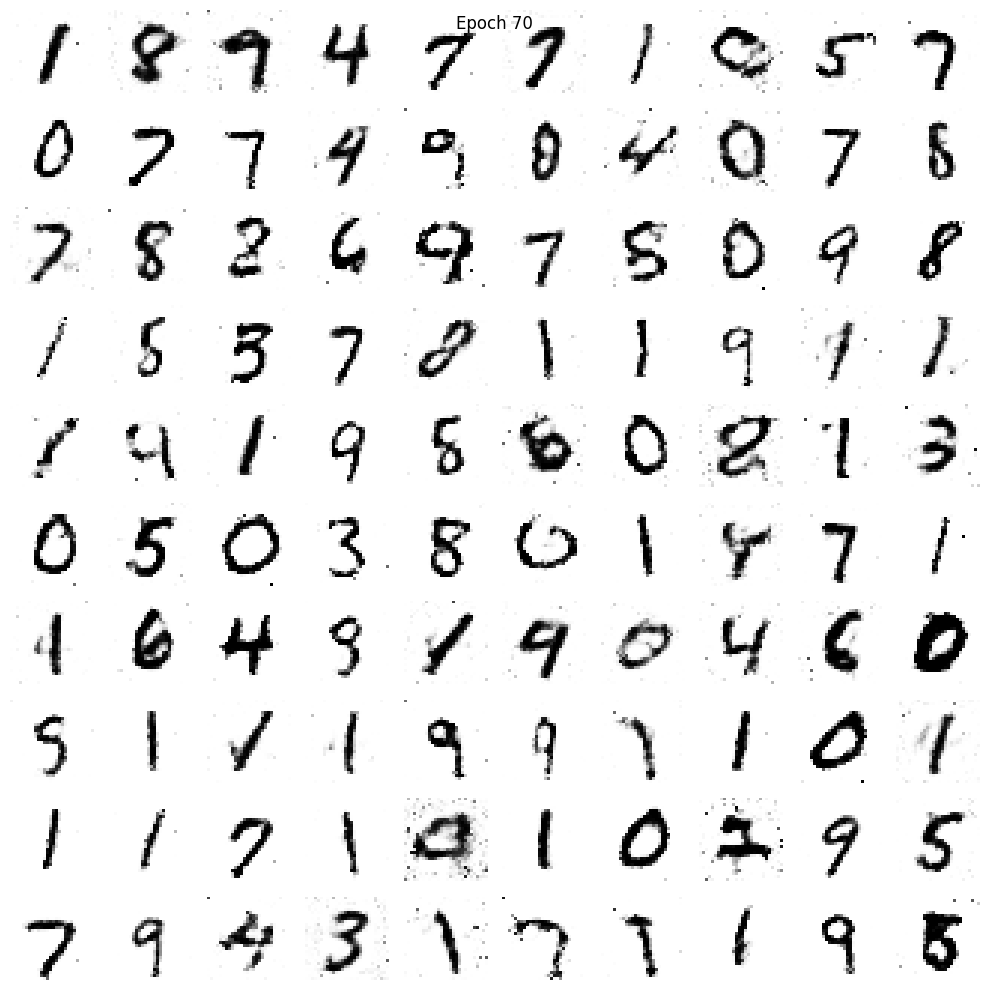

In [ ]:
plotGeneratedImages(70)

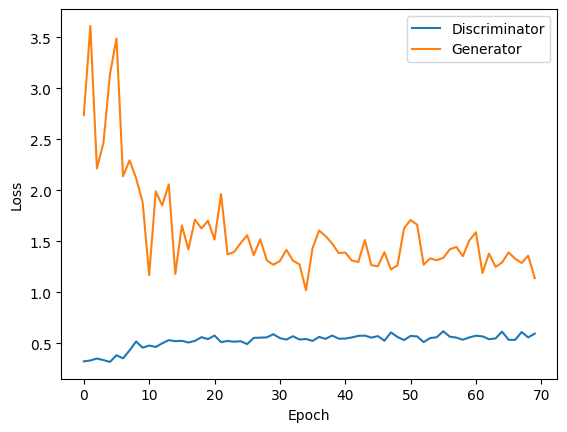

In [ ]:

#plot(d_losses,epochs)
plt.figure()
epochs_t = np.arange(0,epochs,1)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(epochs_t,d_losses, label='Discriminator')
plt.plot(epochs_t,g_losses, label='Generator')
plt.legend()

**Question** Inspect the loss curves for this model and explain what happens.

The loss of the discriminator slightly increases when the number of epochs increases. However, the loss of the generator decreases with each epoch. These results can be explained by the discriminator and generator competing against each other. So if the generator improves, the discriminator gets a higher loss. When using 75 epochs, the curves are spiky and the losses have not converged.

## A convolutional model
Thus far the discriminator and generator were both multilayer perceptrons. Now we're going to add in some convolutional layers to turn them into a deep convolutional GAN (<a href="http://arxiv.org/abs/1511.06434">DCGAN</a>)-like architecture. This means that we have to redefine the generator network and a discriminator network.

The discriminator network is (almost) the same network that we used in last week's exercise.

In [ ]:
from keras.layers import Conv2D, UpSampling2D, Flatten, Reshape, LeakyReLU, Dropout

def get_discriminator_CNN():
  discriminator = keras.models.Sequential()
  discriminator.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=(1, 28, 28), kernel_initializer=keras.initializers.RandomNormal(stddev=0.02)))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(Dropout(0.3))
  discriminator.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(Dropout(0.3))
  discriminator.add(Flatten())
  discriminator.add(Dense(1, activation='sigmoid'))
  return discriminator

def get_generator_CNN():
  generator = keras.models.Sequential()
  generator.add(Dense(128*7*7, input_dim=latent_dim, kernel_initializer=keras.initializers.RandomNormal(stddev=0.02)))
  generator.add(LeakyReLU(0.2))
  generator.add(Reshape((128, 7, 7)))
  generator.add(UpSampling2D(size=(2, 2)))
  generator.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
  generator.add(LeakyReLU(0.2))
  generator.add(UpSampling2D(size=(2, 2)))
  generator.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='tanh'))
  return generator

Let's build our model like before.

In [ ]:
discriminator = get_discriminator_CNN()
generator = get_generator_CNN()

discriminator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5))
generator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5))

discriminator.trainable = False
z = keras.layers.Input(shape=(latent_dim,))
x = generator(z)
D_G_z = discriminator(x)
gan = keras.models.Model(inputs=z, outputs=D_G_z)
gan.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5))

Train the model using the code below. Inspect the samples that come out.

**Question** What are some differences between these samples and the ones generated by the multilayer perceptron GAN? Can you explain these differences?

The samples generated by the deep convolutional GAN (DCGAN) are less noisy than the ones generated by the multilayer perceptron GAN. The numbers are more recognizable and the lines are clearer. The DCGAN uses convolutional networks, which look for spatial correlations. This makes a DCGAN more fitting for generating images than a multilayer perceptron GAN. DCGAN also uses batch normalization to solve gradient problems and uses different activation functions. The combination of these features caused the DCGAN to generate better samples in this case.

In [ ]:
d_losses = []
g_losses = []

epochs = 50
batch_size = 128

X_train = (train_set_images.reshape(60000, 1, 28, 28).astype(np.float32) - 0.5)/0.5

batch_count = int(X_train.shape[0] / batch_size)
for e in range(epochs):
  for _ in range(batch_count):
    # Get a random set of input noise and images
    noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
    image_batch = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]

    # Generate some fake MNIST images using the generator
    generated_images = generator.predict(noise)

    # Concatenate the fake and real images
    X = np.concatenate([image_batch, generated_images])

    # Labels for generated and real data
    y_dis = np.zeros(2*batch_size)
    # Set reference to 1 for real samples
    y_dis[:batch_size] = 1

    # Train discriminator with this batch of samples
    discriminator.trainable = True
    d_loss = discriminator.train_on_batch(X, y_dis)

    # Train generator with a new batch of generated samples
    noise = np.random.normal(0, 1, size=[batch_size, latent_dim])

    # From the generator's perspective, the discriminator should predict
    # ones for all samples
    y_gen = np.ones(batch_size)

    # Freeze the discriminator part
    discriminator.trainable = False

    # Train the GAN to predict ones
    g_loss = gan.train_on_batch(noise, y_gen)

    # Store loss of most recent batch from this epoch
  d_losses.append(d_loss)
  g_losses.append(g_loss)

  if e % 5 == 0:
    noise = np.random.normal(0, 1, size=[100, latent_dim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(100, 28, 28)
    plotImages(generatedImages, title='Epoch {}'.format(e))
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(0.001)
    saveModels(e)

4/4 [==============================] - 0s 6ms/step


<Figure size 640x480 with 0 Axes>

4/4 [==============================] - 0s 3ms/step


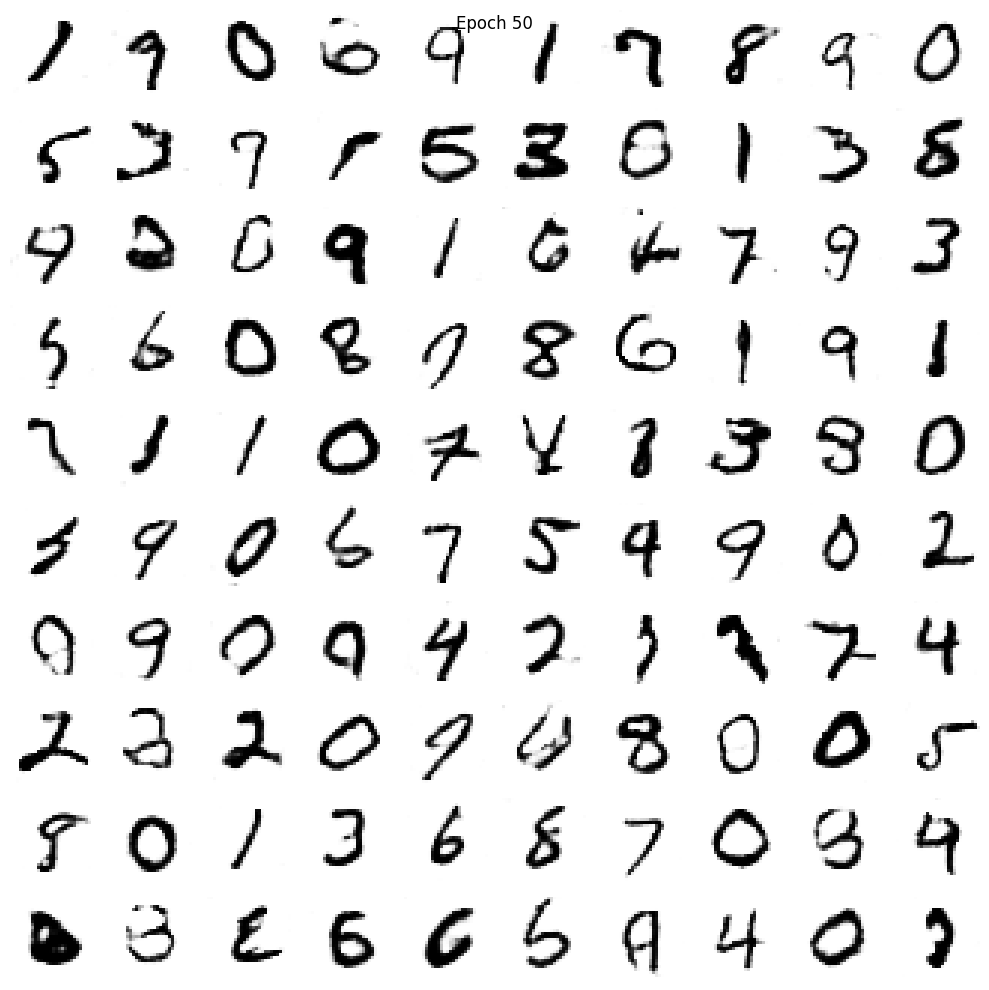

In [ ]:
plotGeneratedImages(50)

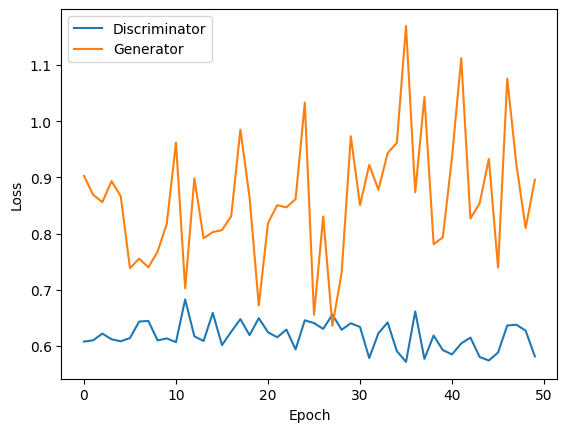

In [ ]:
#plot(d_losses,epochs)
plt.figure()
epochs_t = np.arange(0,epochs,1)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(epochs_t,d_losses, label='Discriminator')
plt.plot(epochs_t,g_losses, label='Generator')
plt.legend()

## Interpolation in the latent space
We're going to explore the latent space a bit more. We pick two points in the latent space and make a linear interpolation between these two. Then we generate images from each of the interpolated latent points.

1/1 [==============================] - 0s 25ms/step


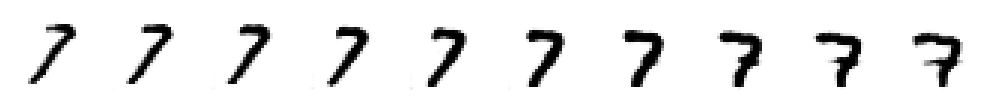

In [ ]:
noise_a = np.random.normal(0, 1, size=[1, latent_dim])
noise_b = np.random.normal(0, 1, size=[1, latent_dim])

noise = np.zeros((10, latent_dim), dtype='float32')
for ni in range(10):
  noise[ni, :] = float(ni)/10. * noise_a + (1 - float(ni)/10.) * noise_b
generatedImages = generator.predict(noise)
generatedImages = generatedImages.reshape(10, 28, 28)
plotImages(generatedImages, dim=(1, 10), figsize=(10, 10))

**Question** Explain what you see in this plot.

This plot shows a row of images with an image of a one on the left and a seven on the right. The images next to the one show the one slowly turning into a seven. The images in between the one and seven are the images generated from the interpolated latent points.

**Question** What happens when you extrapolate out of the latent space distribution? Consider how the noise vectors are drawn.

If you extrapolate out of the latent space distribution, images will be generated outside of the training data distribution. Since the images are not based on training data, they can be unrealistic


# Histopathology image synthesis

Now we're going to synthesize some actual images. We're going to use the PatchCamelyon data set ([more info here](https://github.com/basveeling/pcam)) which consists of small images that can be used for classification benchmarks. Today, we're not going to classify images, but we're going to synthesize them. You can download a data set of smaller (28 x 28 pixels) versions of these images from
[this link](https://drive.google.com/file/d/11tkBWleY6PqFAGQHW0zYOwhvuz0kq-ai/view?usp=sharing). Upload the data set in the dialog below.

In [2]:
uploaded = files.upload()

Saving valid_28.pkl.gz to valid_28.pkl.gz


Now load the data set.

In [3]:
def loadPatchCamelyon(path):
    f = gzip.open(path, 'rb')
    train_set = pickle.load(f, encoding='latin1')
    f.close()
    return train_set

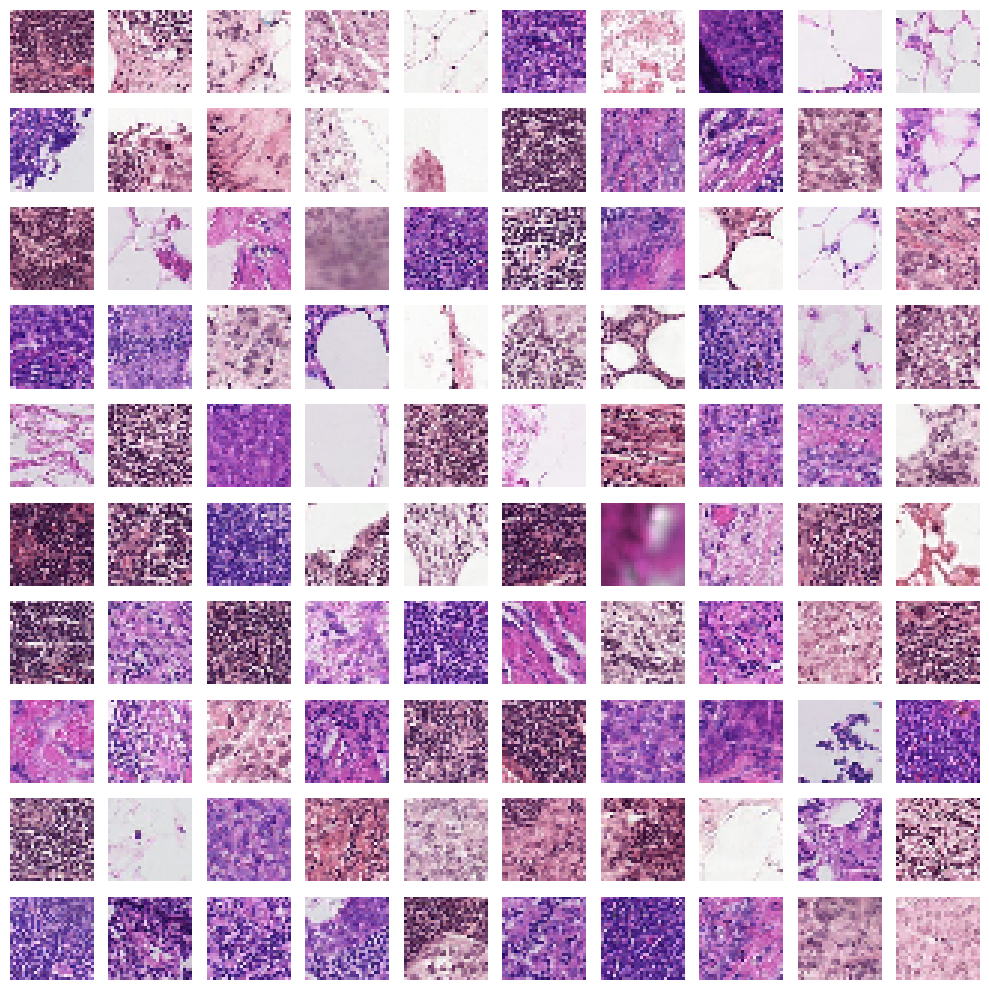

In [4]:
train_set_images = loadPatchCamelyon(r'valid_28.pkl.gz')

def plotImagesPatchCamelyon(images, dim=(10, 10), figsize=(10, 10), title=''):
    plt.figure(figsize=figsize)
    for i in range(images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.suptitle(title)
    plt.show()


plotImagesPatchCamelyon(train_set_images[np.random.randint(0, train_set_images.shape[0], size=100)].reshape(100, 28, 28, 3)/255.0)

What do you immediately notice? Indeed, these images are in color! So the generator will have to generate three output channels instead of just one.

In this second-to-last part of the practical you're going to repurpose the code that you have used so far to synthesize histopathology images like the ones above. You can play around a bit with this, see what happens when you interpolate between samples, etc. Remember that there is a final 'exercise' below.

**Good luck!**

In [7]:
latent_dim = 10

def saveModels(epoch):
    generator.save('gan_generator_epoch_{}.h5'.format(epoch))
    discriminator.save('gan_discriminator_epoch_{}.h5'.format(epoch))

def plotGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, latent_dim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(examples, 28, 28,3)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i])
        plt.axis('off')
    plt.tight_layout()
    plt.suptitle('Epoch {}'.format(epoch))
    plt.show()

def plotImagesPatchCamelyon(images, title='', figsize=(10,10), dim=(10,10)):
    plt.figure(figsize=figsize)
    for i in range(images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.suptitle(title)
    plt.show()

In [6]:
from keras.layers import Dense, LeakyReLU, Dropout
from keras.models import Sequential
from keras.initializers import RandomNormal
from keras.optimizers import Adam
from keras.layers import Conv2D, UpSampling2D, Flatten, Reshape

def get_discriminator_CNN():
  discriminator = keras.models.Sequential()
  discriminator.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=(3, 28, 28), kernel_initializer=keras.initializers.RandomNormal(stddev=0.02)))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(Dropout(0.3))

  discriminator.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(Dropout(0.3))

  discriminator.add(Flatten())
  discriminator.add(Dense(1, activation='sigmoid'))
  return discriminator


def get_generator_CNN():
  generator = keras.models.Sequential()
  generator.add(Dense(128*7*7, input_dim=latent_dim, kernel_initializer=keras.initializers.RandomNormal(stddev=0.02)))
  generator.add(LeakyReLU(0.2))
  generator.add(Reshape((128, 7, 7)))
  generator.add(UpSampling2D(size=(2, 2)))
  generator.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
  generator.add(LeakyReLU(0.2))
  generator.add(UpSampling2D(size=(2, 2)))
  generator.add(Conv2D(3, kernel_size=(5, 5), padding='same', activation='tanh'))
  return generator

discriminator = get_discriminator_CNN()
generator = get_generator_CNN()

discriminator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5))
generator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5))

discriminator.trainable = False
z = keras.layers.Input(shape=(latent_dim,))
x = generator(z)
D_G_z = discriminator(x)
gan = keras.models.Model(inputs=z, outputs=D_G_z)
gan.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5))



In [7]:
d_losses = []
g_losses = []

epochs = 35
batch_size = 128

x_train = (train_set_images / 255.0).astype(np.float32)
train_set_images = np.expand_dims(x_train, axis=-1)

X_train = (train_set_images.reshape(48000, 3, 28, 28).astype(np.float32) - 0.5)/0.5

batch_count = int(X_train.shape[0] / batch_size)
for e in range(epochs):
  for _ in range(batch_count):
    # Get a random set of input noise and images
    noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
    image_batch = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]

    # Generate some fake images using the generator
    generated_images = generator.predict(noise)

    # Concatenate the fake and real images
    X = np.concatenate([image_batch, generated_images])

    # Labels for generated and real data
    y_dis = np.zeros(2*batch_size)
    # Set reference to 1 for real samples
    y_dis[:batch_size] = 1

    # Train discriminator with this batch of samples
    discriminator.trainable = True
    d_loss = discriminator.train_on_batch(X, y_dis)

    # Train generator with a new batch of generated samples
    noise = np.random.normal(0, 1, size=[batch_size, latent_dim])

    # From the generator's perspective, the discriminator should predict
    # ones for all samples
    y_gen = np.ones(batch_size)

    # Freeze the discriminator part
    discriminator.trainable = False

    # Train the GAN to predict ones
    g_loss = gan.train_on_batch(noise, y_gen)

    # Store loss of most recent batch from this epoch
  d_losses.append(d_loss)
  g_losses.append(g_loss)

  if e % 5 == 0:
    noise = np.random.normal(0, 1, size=[100, latent_dim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(300, 28, 28)
    plotImagesPatchCamelyon(generatedImages, dim=(30, 10), figsize=(10, 10))
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(0.001)
    saveModels(e)


4/4 [==============================] - 0s 4ms/step


<Figure size 640x480 with 0 Axes>

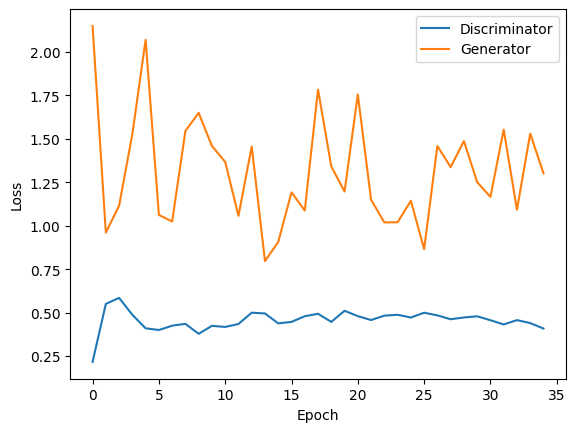

In [8]:
#looking at loss functions to determine quality of model.
plt.figure()
epochs_t = np.arange(0,epochs,1)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(epochs_t,d_losses, label='Discriminator')
plt.plot(epochs_t,g_losses, label='Generator')
plt.legend()

4/4 [==============================] - 0s 3ms/step


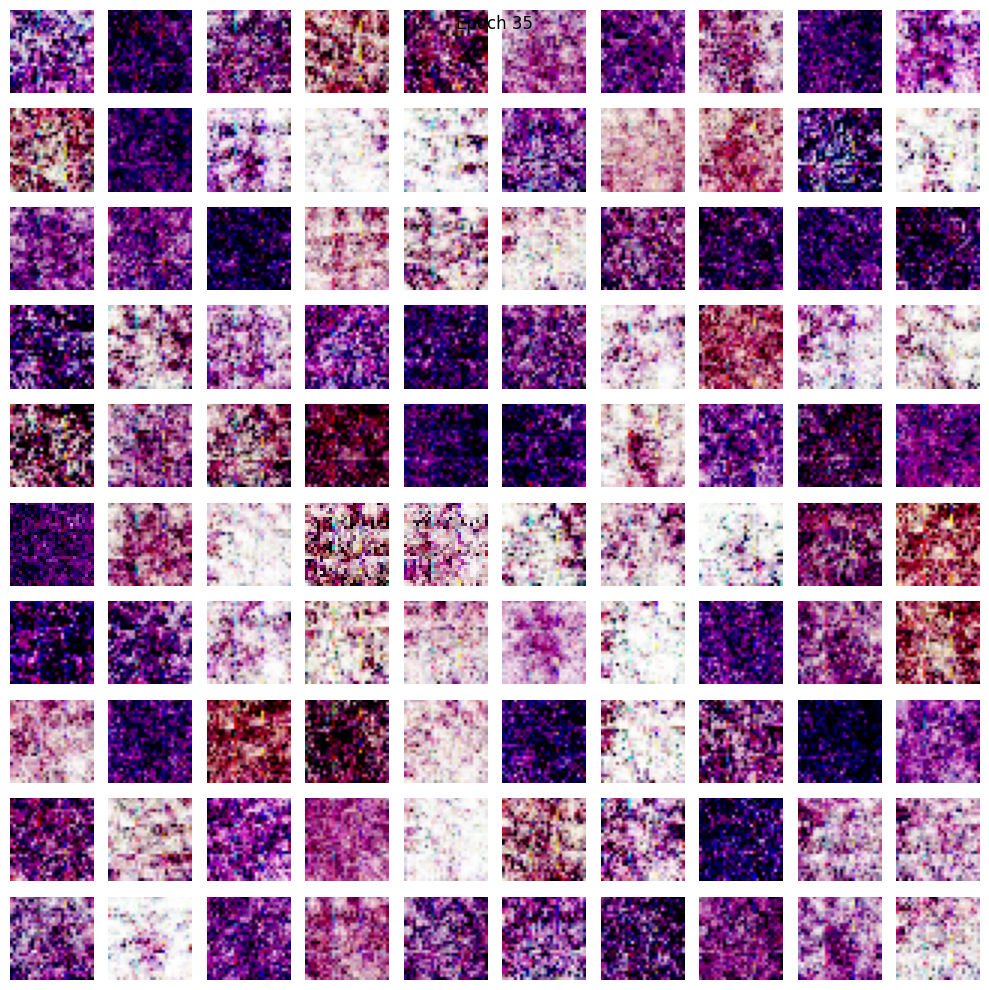

In [9]:
plotGeneratedImages(35)

# Conditional image synthesis

## The BigGAN model
The images we have synthesized so far are all quite small. Synthesis of larger images (e.g. 512 x 512 pixels) typically requires a lot of compute power and patience. Unfortunately, you don't have 100s of GPU at your disposal (I guess) to train a model like BigGAN, the state of the art in conditional image synthesis. A wild guess is that it would cost you around [USD60000](https://twitter.com/quasimondo/status/1065610256917692416) to train this model.

Luckily, the authors of BigGAN have put a version of their pretrained model online and you can use it to synthesize images. Go to [this Colaboratory file](https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/biggan_generation_with_tf_hub.ipynb) and answer the following questions.

**Question** What happens when you change the noise seed? Also try out different categories.

**Answer** When you change the noise seed, you are introducing more random variatioin into the generation process. Each seed value produces a unique randomization of the model's latent space, resulting in different synthesized images. If there was no random input to the generator network, it would create the same synthetic data example over and over. The noise acts as a random seed.

**Question** What happens to your samples when you change the truncation value? More precisely, what happens to the diversity and the quality of your samples? Take a look at the [paper on arXiv](https://arxiv.org/abs/1809.11096) Sec. 3.1 to get an idea what this value does.

**Answer** The truncation value (truncation trick) is a parameter that allows control over the trade-off between individual sample quality and the overall sample variety. A lower truncation value will produce images that are closer to the average of the model's training data, resulting in higher image quality but reduced diversity. In contrast, a higher truncation value will introduce more randomness, increasing diversity but potentially decreasing image quality.


**Question** Interpolate between image categories, inspect what these look like.

**Answer** As you interpolate between categories, you can observe a smooth transformation of generated images from one category to another.




## Conditional MNIST synthesis
For all MNIST samples we already have labels (0, 1, ..., n). Try to change the MNIST synthesis code such that you can ask the generator to generate specific labels. I.e., try to train a conditional GAN. You can look for some inspiration in [this paper](https://arxiv.org/pdf/1411.1784.pdf), in particular Sec. 4.1. Remember that you already got the MNIST labels when loading the data set.

In [4]:
import numpy as np
from tensorflow import keras
from keras.layers import Dense, LeakyReLU, Dropout, Input, concatenate
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.datasets import mnist
import matplotlib.pyplot as plt

# Load and preprocess the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = (x_train / 255.0).astype(np.float32)
x_test = (x_test / 255.0).astype(np.float32)
x_train = x_train.reshape(x_train.shape[0], 784)

num_classes = 10
latent_dim = 100

# One-hot encode the labels
train_set_labels = to_categorical(y_train, num_classes=10)
test_set_labels = to_categorical(y_test, num_classes=10)

# Generator
def get_generator():
    noise = Input(shape=(latent_dim,))
    label = Input(shape=(num_classes,))
    x = concatenate([noise, label])
    x = Dense(256,input_dim=latent_dim, kernel_initializer=keras.initializers.RandomNormal(stddev=0.02))(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(512)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(1024)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(784, activation='tanh')(x)
    model = keras.models.Model(inputs=[noise, label], outputs=x)
    return model

# Discriminator
def get_discriminator():
    image = Input(shape=(784,))
    label = Input(shape=(num_classes,))
    x = concatenate([image, label])
    x = Dense(1024,input_dim=784, kernel_initializer=keras.initializers.RandomNormal(stddev=0.02))(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)
    x = Dense(512)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)
    x = Dense(256)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(1, activation='sigmoid')(x)
    model = keras.models.Model(inputs=[image, label], outputs=x)
    return model

# GAN
def get_gan(generator, discriminator):
    noise = Input(shape=(latent_dim,))
    label = Input(shape=(num_classes,))
    generated_image = generator([noise, label])
    discriminator.trainable = False
    valid = discriminator([generated_image, label])
    model = keras.models.Model(inputs=[noise, label], outputs=valid)
    return model

# Compile the discriminator
discriminator = get_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))

# Compile the generator
generator = get_generator()
generator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))

# Combine the generator and discriminator into a GAN
discriminator.trainable = False
gan = get_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))

# Training loop
d_losses = []
g_losses = []

epochs = 35
batch_size = 128

batch_count = x_train.shape[0] // batch_size

for e in range(epochs):
    for _ in range(batch_count):
        # Select a random batch of images
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        real_images, labels = x_train[idx], train_set_labels[idx]

        # Generate random noise
        noise = np.random.normal(0, 1, size=(batch_size, latent_dim))

        # Generate fake images with specific labels
        generated_images = generator.predict([noise, labels])

        # Create labels for real and fake images
        y_gen = np.ones((batch_size, 1))
        y_dist = np.zeros((batch_size, 1))

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch([real_images, labels], y_gen)
        d_loss_fake = discriminator.train_on_batch([generated_images, labels], y_dist)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator
        noise = np.random.normal(0, 1, size=(batch_size, latent_dim))
        g_loss = gan.train_on_batch([noise, labels], y_gen)

    d_losses.append(d_loss)
    g_losses.append(g_loss)

    if e % 5 == 0:
        print(f"Epoch {e}, D Loss: {d_loss}, G Loss: {g_loss}")
        # Generate some example images
        noise = np.random.normal(0, 1, size=(100, latent_dim))
        labels = to_categorical(np.arange(10).repeat(10), num_classes=num_classes)
        generated_images = generator.predict([noise, labels])
        generated_images = generated_images.reshape(100, 28, 28)

        plt.figure(figsize=(10, 10))
        for i in range(100):
            plt.subplot(10, 10, i+1)
            plt.imshow(generated_images[i], cmap='gray')
            plt.axis('off')
        plt.show()

        # Save the models
        generator.save(f'generator_epoch_{e}.h5')
        discriminator.save(f'discriminator_epoch_{e}.h5')

Output hidden; open in https://colab.research.google.com to view.

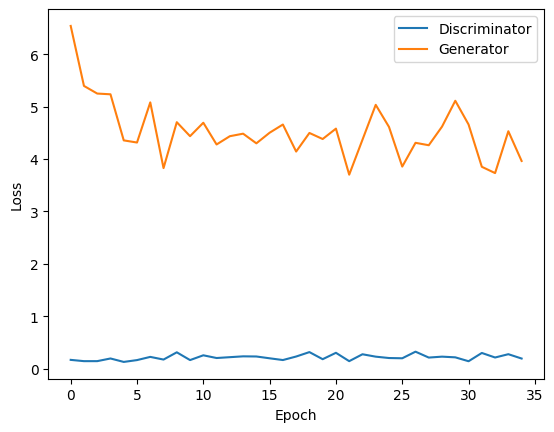

In [5]:
plt.figure()
epochs_t = np.arange(0,epochs,1)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(epochs_t,d_losses, label='Discriminator')
plt.plot(epochs_t,g_losses, label='Generator')
plt.legend()

In [17]:
def saveModels(epoch):
    generator.save('gan_generator_epoch_{}.h5'.format(epoch))
    discriminator.save('gan_discriminator_epoch_{}.h5'.format(epoch))

def plotGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=(100, latent_dim))
    labels = to_categorical(np.arange(10).repeat(10), num_classes=num_classes)
    generated_images = generator.predict([noise, labels])
    generated_images = generated_images.reshape(100, 28, 28)

    plt.figure(figsize=(10, 10))
    for i in range(generatedImages.shape[0]):
      plt.subplot(10, 10, i+1)
      plt.imshow(generated_images[i], cmap='gray')
      plt.axis('off')
    plt.show()
    plt.figure(figsize=figsize)


In [40]:
#examples=100;
#noise = np.random.normal(0, 1, size=[examples, latent_dim])
#generatedImages = generator.predict([noise, test_set_labels[0:100]])
#generatedImages = generatedImages.reshape(examples, 28, 28)

#plt.figure(figsize=figsize)
#for i in range(generatedImages.shape[0]):

#    plt.subplot(dim[0], dim[1], i+1)
#    plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray_r')
#    plt.axis('off')
#    plt.tight_layout()
#    plt.suptitle('Epoch {}'.format(epoch))
#    plt.show()